# Predicting Monkey Arm Movememnts via Electrode Signals - Dataset

Import libraries

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from google.colab import drive
!pip install --upgrade tsmoothie
from tsmoothie.smoother import LowessSmoother

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Connect dataset from Google Drive

In [ ]:
drive.mount('/content/drive')
path = "drive/MyDrive/CS230_Project/Jenkins_Rstruct_Data"
!ls $path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
JR_2015-12-04_truncated2.mat  plan_test_data.mat  plan_training_data.mat


## Dataset information

In [ ]:
import scipy.io as sio
R = sio.loadmat(path+"/JR_2015-12-04_truncated2.mat")["R"][0]
ntrials = len(R)
shape = R[0]['spikeRaster'].todense().shape
fields = R[0].dtype.names

print("There are %d trials in the R-struct" % ntrials)
print("There are %d electrodes with %d millseconds of data \n" % (shape[0], shape[1]))
print("Fields in this dataset include: ")
for field in fields:
    print("-", field)

There are 506 trials in the R-struct
There are 96 electrodes with 901 millseconds of data 

Fields in this dataset include: 
- startDateNum
- startDateStr
- timeTargetOn
- timeTargetAcquire
- timeTargetHeld
- timeTrialEnd
- subject
- counter
- state
- cursorPos
- spikeRaster
- spikeRaster2
- isSuccessful
- trialNum
- timeFirstTargetAcquire
- timeLastTargetAcquire
- trialLength
- target


The fields we care about the most are `target` and `spikeRaster`.

The `target` field holds the coordinates of the reach direction of a given trial.
```python
# returns a tuple indicating the x, y, and z coordinates
# of the target reach direction for trial 0
R[0]['target']
```
The `spikeRaster` field holds a sparse matrix where each row corresponds to an electrode, and each column corresponds to a spike time. We will use the `.todense()` function to convert the row to an array of 1s and 0s where each index is a millisecond indicating whether a neuron fired (1) or not (0).
```python
# returns an array of spikes for the first trial and
# and the first electrode
R[0]['spikeRaster'].todense()[0, :]
# returns whether there was a spike for the first trial and
# and the first electrode during the 10th millisecond
R[0]['spikeRaster'].todense()[0,9]
```

There are 9 possible reach directions.
```python
# Targets sorted in CCW
xy_sorted = np.array([
             [0.0, 0.0],          # 0
             [120.0, 0.0],          # 1
             [84.85, 84.85],        # 2
             [0.0,   120.0],        # 3
             [-84.85,84.85],        # 4
             [-120.0, 0],           # 5
             [-84.85, -84.85],      # 6
             [0.0, -120],           # 7
             [84.85,-84.85]])       # 8
```

### Raster plot of the data

In [ ]:
def plotRaster(S):
    """
    plotRaster:
    -----------
    - S: spike train
    -----------
    - creates a raster plot of the spikes
    """
    gap = 3
    mark = 5
    pad = 30
    numSpikeTrain = len(S);
    plt.figure()
    for s in range(numSpikeTrain):
        offset = pad + gap + s*(gap+mark);
        train = S[s]
        for t in train:
            plt.plot([t, t], [offset, offset+mark],'black')
        
    plt.xlabel('Time (ms)')
    plt.ylim([0,offset+mark+gap+pad])
    plt.yticks([])
    plt.grid(axis='x')

Text(0.5, 1.0, 'Raster Plot for Electrode 17')

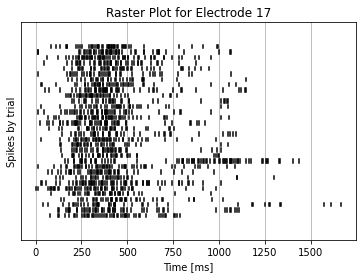

In [ ]:
num_reaches = 32
electrode_number = 17
spike_train = np.zeros((num_reaches), dtype=object)
ix = 0
for trial in R:
    target = trial["target"]
    
    if (target[0]==120 and target[1] == 0):
        spike_train[ix] =  np.where(trial["spikeRaster"].todense()[electrode_number - 1,:])[1]
        ix += 1
    
plotRaster(spike_train);
plt.xlabel('Time [ms]')
plt.ylabel('Spikes by trial')
plt.title('Raster Plot for Electrode 17')

## Restructure the data

### Seperate data per reach, shift middle reaches, and apply pretraining

In [ ]:
def seperate_reaches(R, n_reach_trials, num_electrodes, ms_start, ms, reaches, middle_reach={}, shift_middle=True):
    """
    seperate_reaches:
    -----------------
    - R: neural data
    - n_reach_trials: number of trials we care about
    - num_electrodes: number of electrodes we want to account for
    - ms_start: start index of timeseries spikes
    - ms: length of timeseries
    - reaches: dict of possible reach directions (should have length of 8 if shift_middle is True)
    - middle_reach: dict of mappings for shifting middle reaches
    - shift_middle: boolean indicating if we want to shift the middle
    -----------------
    - Seprates data by reach direction
    - Translates middle movements to reaches from previous point
    """
    if shift_middle and len(reaches) == 9:
        raise Exception("shift_middle is true which means len(reaches) should be 8")
    if not shift_middle and len(reaches) == 8:
        raise Exception("shift_middle is false which means len(reaches) should be 9")
    spike_times = np.ndarray(shape=(n_reach_trials, num_electrodes, ms))
    # pre training
    smoother = LowessSmoother(smooth_fraction=0.1, iterations=1)
    print(spike_times[0])
    smoother.smooth(spike_times[0])
    targets = np.ndarray(shape=(n_reach_trials, 1), dtype=int)

    count = {} # verify counts per reach
    per_reach = {} # seperate spikes per reach
    prev = (round(R[0]['target'][0].item(), 2), round(R[0]['target'][1].item(), 2))

    total = 0
    for n in range(n_reach_trials):
        spike_time = R[n]['spikeRaster'].todense()[:, ms_start: ms_start + ms]
        target_x = round(R[n]['target'][0].item(), 2)
        target_y = round(R[n]['target'][1].item(), 2)
        # first check if middle
        if target_x == round(0.0, 2) and target_y == round(0.0, 2) and shift_middle:
            target_x = round(middle_reach_dict[prev[0]], 2)
            target_y = round(middle_reach_dict[prev[1]], 2)
        for d, dir in enumerate(reaches):
            if target_x == round(dir[0], 2) and target_y == round(dir[1], 2):
                prev = (target_x, target_y)
                if d not in count:
                    count[d] = 0
                    per_reach[d] = []
                per_reach[d].append(spike_time)
                count[d] += 1
                # col[d] = 1
                targets[total, :] = d
                spike_times[total, :, :] = spike_time
                total += 1
                break
    return spike_times, targets, count, per_reach

In [ ]:
n_reach_trials = ntrials - 1 # remove first middle reach
num_electrodes = 96
ms = 300
ms_start = 200

xy_sorted = np.array([
             [120.0, 0.0],
             [84.85, 84.85],
             [0.0, 120.0],
             [-84.85,84.85],
             [-120.0, 0],
             [-84.85, -84.85],
             [0.0, -120],
             [84.85,-84.85]])
xy_sorted_middle = np.array([
             [0.0, 0.0],
             [120.0, 0.0],
             [84.85, 84.85],
             [0.0, 120.0],
             [-84.85,84.85],
             [-120.0, 0],
             [-84.85, -84.85],
             [0.0, -120],
             [84.85,-84.85]])
middle_reach_dict = {
    0.0: 0.0,
    -84.85: 84.85,
    84.85: -84.85,
    -120.0: 120.0,
    120.0: -120.0,
}

In [ ]:
spike_times, targets, count, per_reach = seperate_reaches(R, n_reach_trials, num_electrodes, ms_start, ms, xy_sorted, middle_reach_dict, shift_middle=True)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
spike_times.shape, targets.shape, count, len(per_reach) # verify

((505, 96, 300),
 (505, 1),
 {6: 63, 2: 63, 5: 62, 1: 62, 0: 64, 4: 64, 3: 63, 7: 63},
 8)

### Evenly Sample From Each Class

In [ ]:
import sklearn.model_selection as sk

def even_sample(train_size, n_reach_trials, num_electrodes, ms, count, per_reach):
    # get num_train and num_test manually b/c of rounding errors
    num_train = 0
    num_test = 0
    for c in count:
        num_train += int(train_size * count[c])
        num_test += int((1 - train_size) * count[c])
    print(num_train, num_test, n_reach_trials - num_train)
    # initialize training and test sets
    X_train = np.ndarray(shape=(num_train, num_electrodes, ms))
    X_test = np.ndarray(shape=(n_reach_trials - num_train, num_electrodes, ms))
    Y_train = np.ndarray(shape=(num_train, 1), dtype=int)
    Y_test = np.ndarray(shape=(n_reach_trials - num_train, 1), dtype=int)

    train_start = 0
    test_start = 0
    test = 0
    train = 0
    for d in per_reach:
        reach = np.array(per_reach[d])
        target = np.full((reach.shape[0], 1), d)
        reach_x_train, reach_x_test, reach_y_train, reach_y_test = sk.train_test_split(reach, target, train_size=train_size, random_state = 42)
        train += len(reach_y_train)
        test += len(reach_y_test)
        X_train[train_start: train_start + reach_x_train.shape[0], :, :] = reach_x_train
        X_test[test_start: test_start + reach_x_test.shape[0], :, :] = reach_x_test
        Y_train[train_start: train_start + reach_y_train.shape[0], :] = reach_y_train
        Y_test[test_start: test_start + reach_y_test.shape[0], :] = reach_y_test
        train_start += reach_x_train.shape[0]
        test_start += reach_x_test.shape[0]
    return X_train, Y_train, X_test[:test], Y_test[:test]

In [ ]:
raw_x_train, raw_y_train, raw_x_test, raw_y_test = even_sample(.7, n_reach_trials, num_electrodes, ms, count, per_reach)

350 146 155


In [ ]:
raw_x_train.shape

(350, 96, 300)